In [1]:
import math
import numpy as np

from scipy.optimize import brentq
from dps_lake_model import lake_model, get_antropogenic_release


from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging,
                           Constant, Constraint, Policy, IpyparallelEvaluator, perform_experiments,
                           SequentialEvaluator, Scenario)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D 
from ema_workbench.analysis import parcoords
import itertools
import copy

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [2]:
#define model
model = Model('dpslake', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                          RealParameter('q', 2.0, 4.5),
                          RealParameter('mean', 0.01, 0.05),
                          RealParameter('stdev', 0.001, 0.005),
                          RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                   RealParameter("c2", -2, 2),
                   RealParameter("r1", 0, 2),
                   RealParameter("r2", 0, 2),
                   RealParameter("w1", 0, 1)]

#model.constantcs = [Constant('alpha', 0.41),
#                         Constant('reps', 150)],

In [3]:
#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

#specify constraints which would lead to the worst cases: high max_P, low utility, low reliability (not used)
constraints = [Constraint("low reliability", outcome_names="reliability",
                          function=lambda x:max(0, x-0.25)),
               Constraint("high pollution", outcome_names="max_P",
                          function=lambda x:max(0, 6-x)),
               Constraint("low utility", outcome_names="utility",
                          function=lambda x:max(0, x-0.25))]

In [4]:
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [5]:
experiments

,b,delta,mean,q,stdev,scenario,policy,model
0,0.384032,0.949710,0.011834,3.758726,0.002534,0,None,dpslake
1,0.434786,0.970097,0.016943,3.940615,0.002460,1,None,dpslake
2,0.389811,0.964919,0.035578,2.756957,0.001578,2,None,dpslake
3,0.159308,0.977866,0.011269,3.009122,0.004435,3,None,dpslake
4,0.156603,0.932904,0.017095,2.471114,0.003360,4,None,dpslake
...,...,...,...,...,...,...,...,...
995,0.224694,0.961369,0.023700,3.438103,0.002351,995,None,dpslake
996,0.126655,0.973089,0.044614,3.341911,0.002958,996,None,dpslake
997,0.216761,0.938113,0.044899,2.729800,0.003774,997,None,dpslake
998,0.226713,0.979605,0.031207,3.885848,0.004420,998,None,dpslake


In [6]:
outcomes = pd.DataFrame.from_dict(outcomes)
outcomes

,max_P,utility,inertia,reliability
0,0.111737,0.265660,0.9900,1.0000
1,0.117055,0.394512,0.9900,1.0000
2,0.135579,0.208252,0.9900,1.0000
3,0.160761,0.240780,0.9900,1.0000
4,7.084139,0.299770,0.9723,0.1224
...,...,...,...,...
995,0.158488,0.175140,0.9900,1.0000
996,9.031734,1.135253,0.9716,0.0908
997,5.233010,0.393875,0.9715,0.1168
998,0.191133,0.243762,0.9900,1.0000


<font color='green'>
Here, we select scenarios which lead to the worst cases: high max_P, low utility, low reliability. We left inertia from further consideration because the values it resulted throughout all experiments were not significantly different. Whether low or high is identified by comparing with its 11 percentile, instead of median. That is because after implementing the 'median' selection, we get 897 results of scenario. Considering the large number of scenarios, we would like to narrow it by selecting the scenario based on 11th percentile so that they would more represent worst cases.
</font>

In [7]:
oois = ['max_P', 'reliability', 'utility']
oois

['max_P', 'reliability', 'utility']

In [12]:
np.percentile(outcomes[ooi], 89)

0.8467148779805609

In [32]:
#here, the policy-relevant scenarios defined by 89 and 11 percentile are selected
indices = []
for ooi in oois:
    if ooi in ['max_P']:
        a = outcomes[ooi] > np.percentile(outcomes[ooi], 67)
    else: 
        a = outcomes[ooi] < np.percentile(outcomes[ooi], 33)
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.all() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

In [33]:
newOutcomes

{'max_P': 94     3.393767
 134    7.790478
 214    4.302638
 274    6.351039
 316    4.364329
 358    4.178247
 521    3.050541
 643    4.115151
 669    8.762873
 851    8.033387
 862    9.535508
 927    5.415379
 Name: max_P, dtype: float64,
 'reliability': 94     0.5155
 134    0.4749
 214    0.4274
 274    0.5955
 316    0.6574
 358    0.6445
 521    0.3816
 643    0.4390
 669    0.6984
 851    0.3315
 862    0.5379
 927    0.3655
 Name: reliability, dtype: float64,
 'utility': 94     0.148659
 134    0.181438
 214    0.168418
 274    0.185902
 316    0.178974
 358    0.147182
 521    0.173103
 643    0.180857
 669    0.143376
 851    0.196733
 862    0.198420
 927    0.198420
 Name: utility, dtype: float64}

In [38]:
#selecting 4 scenarios which have the worst max_P values
newOutcomes = pd.DataFrame.from_dict(newOutcomes)
newOutcomes = newOutcomes.sort_values(by='max_P', ascending=False)
selectedcases = newOutcomes.head(4)
selected = list(selectedcases.index)
selected

[862, 669, 851, 134]

In [41]:
sel_col = ["unselected cases" for x in range (len(outcomes))]
count = 0
for i in enumerate(sel_col):
    if count in selected:
        sel_col[count] = "worst cases selected"
    count +=1

In [42]:
data = copy.copy(outcomes)
data['scenarios'] = sel_col
data

,max_P,utility,inertia,reliability,scenarios
0,0.111737,0.265660,0.9900,1.0000,unselected cases
1,0.117055,0.394512,0.9900,1.0000,unselected cases
2,0.135579,0.208252,0.9900,1.0000,unselected cases
3,0.160761,0.240780,0.9900,1.0000,unselected cases
4,7.084139,0.299770,0.9723,0.1224,unselected cases
...,...,...,...,...,...
995,0.158488,0.175140,0.9900,1.0000,unselected cases
996,9.031734,1.135253,0.9716,0.0908,unselected cases
997,5.233010,0.393875,0.9715,0.1168,unselected cases
998,0.191133,0.243762,0.9900,1.0000,unselected cases


C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


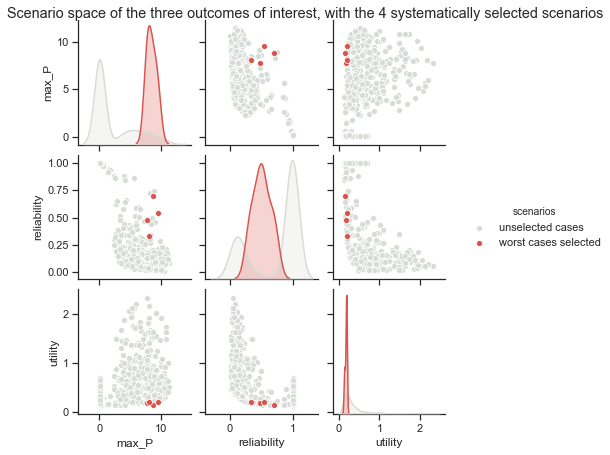

In [43]:
sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["light grey", "pale red"]

#for entry, name in zip(np.unique(sel_column), ['any', 'policy relevant','prim', 'diversity_selected', 'random_selected']):
#    data.replace(entry, name, inplace=True)

g = sns.pairplot(data, hue='scenarios', size=2, palette=sns.xkcd_palette(colors), vars=oois)

plt.suptitle("Scenario space of the three outcomes of interest, with the 4 systematically selected scenarios", y=1.02)

tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}   

#g.savefig('./figs/mordm/scatter_diverse_random_prim.png', dpi=600)
plt.show()

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


<font color='green'>Here are the scenarios selected:</font>

In [44]:
wc = experiments.iloc[selected]
wc

,b,delta,mean,q,stdev,scenario,policy,model
862,0.117009,0.950548,0.021253,4.126973,0.001109,862,None,dpslake
669,0.114163,0.936504,0.011725,3.408186,0.003828,669,None,dpslake
851,0.140999,0.934675,0.032834,4.266484,0.004209,851,None,dpslake
134,0.145342,0.941709,0.033369,4.433544,0.004629,134,None,dpslake


In [45]:
outcomes

,max_P,utility,inertia,reliability
0,0.111737,0.265660,0.9900,1.0000
1,0.117055,0.394512,0.9900,1.0000
2,0.135579,0.208252,0.9900,1.0000
3,0.160761,0.240780,0.9900,1.0000
4,7.084139,0.299770,0.9723,0.1224
...,...,...,...,...
995,0.158488,0.175140,0.9900,1.0000
996,9.031734,1.135253,0.9716,0.0908
997,5.233010,0.393875,0.9715,0.1168
998,0.191133,0.243762,0.9900,1.0000


In [46]:
worstcases = []
for i in range(len(wc)):
    b = wc.iloc[i,0]
    delta = wc.iloc[i,1]
    mean = wc.iloc[i,2]
    q = wc.iloc[i,3]
    stdev = wc.iloc[i,4]
    worstcases.append(Scenario(f"Scenario{i}",**{"b": b, "delta": delta, "mean": mean, "q": q, "stdev": stdev}))
worstcases

[Scenario({'b': 0.11700899158528685, 'delta': 0.9505480557673207, 'mean': 0.021253182183384095, 'q': 4.126973314263388, 'stdev': 0.0011088395975301}),
 Scenario({'b': 0.114163082500159, 'delta': 0.9365036487389707, 'mean': 0.011724645394763826, 'q': 3.408186087057058, 'stdev': 0.003827915377490306}),
 Scenario({'b': 0.14099868873504637, 'delta': 0.9346745679647686, 'mean': 0.0328335021793202, 'q': 4.266484176539727, 'stdev': 0.004209376273901767}),
 Scenario({'b': 0.14534162149611943, 'delta': 0.9417093569457354, 'mean': 0.03336943859592271, 'q': 4.433543677971743, 'stdev': 0.004628573732918081})]

<font color='green'>Here, we refer the experiment to scenario name as below:
- 1st experiment as *Scenario0*
- 2nd experiment as *Scenario1*
- 3rd experiment as *Scenario2*
- 4th experiment as *Scenario3*
</font>

In [53]:
#specify outcomes for worstcases 
# as we want to examine the worst cases, we need to change the outcomes' kind so the direction is undesirable

model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,15)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MINIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

#specify constraints which would lead to the worst cases: high max_P, low utility, low reliability
#they are set in accordance with the criteria of the selected scenarios
constraints = [Constraint("low reliability", outcome_names="reliability",
                          function=lambda x:max(0, x-np.percentile(outcomes['reliability'], 33))), #89 percentile
               Constraint("high pollution", outcome_names="max_P",
                          function=lambda x:max(0, np.percentile(outcomes['max_P'], 67)-x)), #11 percentile
               Constraint("low utility", outcome_names="utility",
                          function=lambda x:max(0, x-np.percentile(outcomes['utility'], 33)))] #11 percentile

### Many-Objective Optimization for Scenario0

In [107]:
with MultiprocessingEvaluator(model) as evaluator:
    results0, convergence0 = evaluator.optimize(nfe=50000, searchover='levers',
                                    epsilons=[0.007, 0.007, 0.007, 0.007],
                                    reference=worstcases[0],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 497/50000 nfe
[MainProcess/INFO] generation 10: 988/50000 nfe
[MainProcess/INFO] generation 15: 1482/50000 nfe
[MainProcess/INFO] generation 20: 1977/50000 nfe
[MainProcess/INFO] generation 25: 2473/50000 nfe
[MainProcess/INFO] generation 30: 2967/50000 nfe
[MainProcess/INFO] generation 35: 3464/50000 nfe
[MainProcess/INFO] generation 40: 3958/50000 nfe
[MainProcess/INFO] generation 45: 4457/50000 nfe
[MainProcess/INFO] generation 50: 4949/50000 nfe
[MainProcess/INFO] generation 55: 5444/50000 nfe
[MainProcess/INFO] generation 60: 5939/50000 nfe
[MainProcess/INFO] generation 65: 6434/50000 nfe
[MainProcess/INFO] generation 70: 6933/50000 nfe
[MainProcess/INFO] generation 75: 7425/50000 nfe
[MainProcess/INFO] generation 80: 7918/50000 nfe
[MainProcess/INFO] generation 85: 8414/50000 nfe
[MainProcess/INFO] generation 90: 8911/50000 nfe
[MainProcess/INFO] generation 95: 9410/50000

In [108]:
results0

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.348164,-0.730051,1.925116,1.907999,0.919585,9.564057,0.181905,0.9746,0.4497
1,1.127900,0.183895,1.369640,1.702479,0.053129,9.548347,0.198454,0.9728,0.4907
2,0.345112,-0.669248,1.999752,1.943470,0.912712,9.525136,0.153895,0.9743,0.5384
3,0.371755,-0.778740,1.988898,1.997304,0.938059,9.445756,0.139901,0.9744,0.6063
4,0.348188,-0.713731,1.980007,1.906213,0.909521,9.570848,0.199138,0.9753,0.4105
5,0.276366,-0.688891,1.980190,1.980215,0.926190,9.391746,0.136400,0.9727,0.6339
6,0.368955,-0.739209,1.990341,1.823664,0.938826,9.542030,0.160948,0.9760,0.5107
7,0.344166,-0.743853,1.978080,1.911446,0.936185,9.497814,0.146984,0.9742,0.5691
8,0.245101,-0.720563,1.992815,1.932839,0.944728,9.302541,0.132494,0.9727,0.6634
9,0.345809,-0.667983,1.971558,1.815800,0.922574,9.551798,0.167654,0.9745,0.4887


In [109]:
convergence0

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.005381,8,100
2,0.008472,53,1185
3,0.008461,73,2277
4,0.008678,87,3364
5,0.008681,100,4457
6,0.008683,107,5544
7,0.008704,119,6634
8,0.008696,132,7720
9,0.008700,137,8811


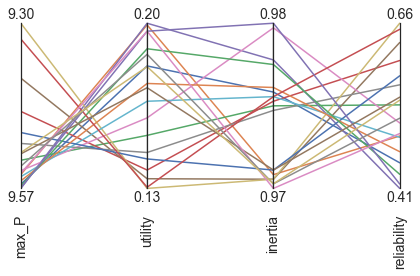

In [110]:
outcomes0 = results0.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits0 = parcoords.get_limits(outcomes0)
axes0 = parcoords.ParallelAxes(limits0)
axes0.plot(outcomes0)

# we invert this axis so direction of desirability is the same 
axes0.invert_axis('max_P') 
plt.show()

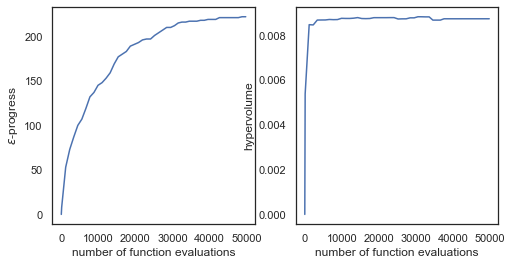

In [111]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence0.nfe, convergence0.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence0.nfe, convergence0.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Many-Objective Optimization for Scenario1

In [112]:
with MultiprocessingEvaluator(model) as evaluator:
    results1, convergence1 = evaluator.optimize(nfe=50000, searchover='levers',
                                    epsilons=[0.007, 0.007, 0.007, 0.007],
                                    reference=worstcases[1],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 499/50000 nfe
[MainProcess/INFO] generation 10: 992/50000 nfe
[MainProcess/INFO] generation 15: 1489/50000 nfe
[MainProcess/INFO] generation 20: 1988/50000 nfe
[MainProcess/INFO] generation 25: 2482/50000 nfe
[MainProcess/INFO] generation 30: 2974/50000 nfe
[MainProcess/INFO] generation 35: 3472/50000 nfe
[MainProcess/INFO] generation 40: 3971/50000 nfe
[MainProcess/INFO] generation 45: 4469/50000 nfe
[MainProcess/INFO] generation 50: 4968/50000 nfe
[MainProcess/INFO] generation 55: 5463/50000 nfe
[MainProcess/INFO] generation 60: 5960/50000 nfe
[MainProcess/INFO] generation 65: 6457/50000 nfe
[MainProcess/INFO] generation 70: 6952/50000 nfe
[MainProcess/INFO] generation 75: 7447/50000 nfe
[MainProcess/INFO] generation 80: 7943/50000 nfe
[MainProcess/INFO] generation 85: 8436/50000 nfe
[MainProcess/INFO] generation 90: 8932/50000 nfe
[MainProcess/INFO] generation 95: 9429/50000

In [113]:
results1

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,1.611382,0.184687,1.337180,1.640268,0.012629,9.714189,0.158874,0.9724,0.4069
1,-1.119840,0.256885,1.765504,1.988255,0.027543,9.682110,0.118750,0.9742,0.4979
2,-1.339836,0.169483,1.694049,1.969453,0.017625,9.719024,0.139537,0.9752,0.4029
3,-1.101833,0.112371,1.768039,1.990099,0.039989,9.730604,0.180662,0.9762,0.3066
4,-1.260182,0.220436,1.770854,1.976581,0.017640,9.282334,0.104947,0.9741,0.6496
5,-1.229914,-0.139500,1.771864,1.987266,0.019089,9.730296,0.167868,0.9767,0.3315
6,-1.227553,0.245498,1.702303,1.959204,0.017557,9.466286,0.108679,0.9723,0.5966
7,-1.260182,-0.080452,1.680809,1.997386,0.017557,9.728208,0.160763,0.9761,0.3444
8,-1.232160,-0.049085,1.778631,1.979865,0.019291,9.714527,0.132553,0.9759,0.4285
9,-1.216573,0.269478,1.681894,1.991949,0.018138,9.622225,0.111951,0.9752,0.5508


In [114]:
convergence1

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.009493,3,100
2,0.010899,63,1190
3,0.011139,96,2284
4,0.011119,114,3373
5,0.011201,127,4469
6,0.011270,143,5563
7,0.011299,153,6657
8,0.011251,164,7744
9,0.011266,172,8832


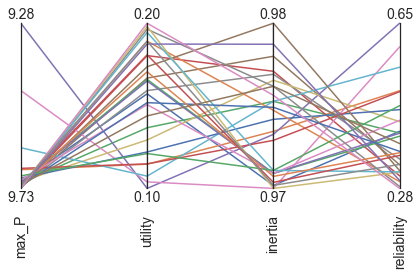

In [115]:
outcomes1 = results1.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits1 = parcoords.get_limits(outcomes1)
axes1 = parcoords.ParallelAxes(limits1)
axes1.plot(outcomes1)

# we invert this axis so direction of desirability is the same 
axes1.invert_axis('max_P') 
plt.show()

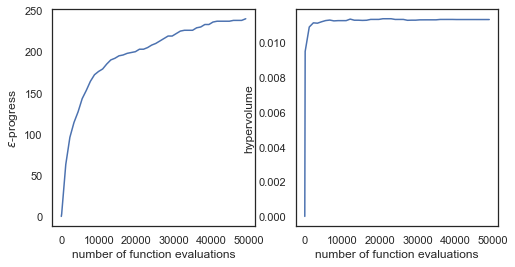

In [116]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence1.nfe, convergence1.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence1.nfe, convergence1.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Many-Objective Optimization for Scenario2

In [122]:
with MultiprocessingEvaluator(model) as evaluator:
    results2, convergence2 = evaluator.optimize(nfe=50000, searchover='levers',
                                    epsilons=[0.007, 0.007, 0.007, 0.007],
                                    reference=worstcases[2],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 495/50000 nfe
[MainProcess/INFO] generation 10: 986/50000 nfe
[MainProcess/INFO] generation 15: 1479/50000 nfe
[MainProcess/INFO] generation 20: 1971/50000 nfe
[MainProcess/INFO] generation 25: 2467/50000 nfe
[MainProcess/INFO] generation 30: 2959/50000 nfe
[MainProcess/INFO] generation 35: 3452/50000 nfe
[MainProcess/INFO] generation 40: 3944/50000 nfe
[MainProcess/INFO] generation 45: 4435/50000 nfe
[MainProcess/INFO] generation 50: 4931/50000 nfe
[MainProcess/INFO] generation 55: 5428/50000 nfe
[MainProcess/INFO] generation 60: 5926/50000 nfe
[MainProcess/INFO] generation 65: 6415/50000 nfe
[MainProcess/INFO] generation 70: 6909/50000 nfe
[MainProcess/INFO] generation 75: 7404/50000 nfe
[MainProcess/INFO] generation 80: 7893/50000 nfe
[MainProcess/INFO] generation 85: 8388/50000 nfe
[MainProcess/INFO] generation 90: 8887/50000 nfe
[MainProcess/INFO] generation 95: 9386/50000

In [123]:
results2

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.200191,0.211607,0.709957,1.062175,0.765895,8.032602,0.144079,0.9729,0.3871
1,0.195680,0.374087,1.135595,0.920585,0.924621,8.029152,0.117801,0.9723,0.4729
2,0.200191,0.256497,0.734062,0.500515,0.528512,8.033368,0.175306,0.9725,0.3611
3,0.200191,0.157213,0.768060,1.438897,0.369472,8.029551,0.123393,0.9725,0.4492
4,0.199820,0.529523,0.552552,1.511359,0.766105,8.033184,0.191056,0.9727,0.3054
5,0.287767,0.965905,1.520686,1.346929,0.871895,8.033291,0.188738,0.9724,0.3451
6,0.020215,-0.006793,1.520100,1.972277,0.117268,8.027267,0.118263,0.9729,0.4650
7,0.153307,-0.416925,1.548008,1.345377,0.913293,8.036422,0.182187,0.9763,0.2893
8,0.251326,-0.316909,0.587582,1.445707,0.994675,8.033204,0.169107,0.9728,0.3815
9,0.322794,-0.684524,1.998859,1.763157,0.919611,8.034127,0.167601,0.9757,0.3069


In [124]:
convergence2

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.008037,6,100
2,0.009449,68,1185
3,0.009493,82,2269
4,0.009381,95,3357
5,0.009386,108,4435
6,0.009387,116,5528
7,0.009393,126,6610
8,0.009500,139,7696
9,0.009695,145,8787


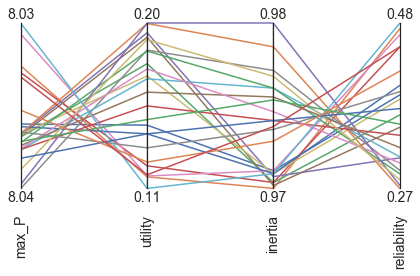

In [125]:
outcomes2 = results2.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits2 = parcoords.get_limits(outcomes2)
axes2 = parcoords.ParallelAxes(limits2)
axes2.plot(outcomes2)

# we invert this axis so direction of desirability is the same 
axes2.invert_axis('max_P') 
plt.show()

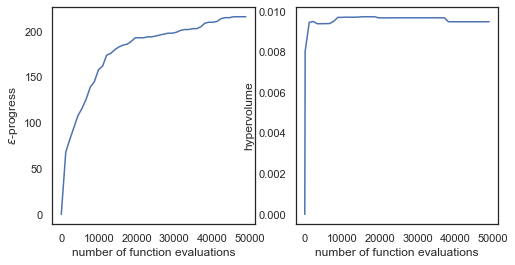

In [126]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence2.nfe, convergence2.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence2.nfe, convergence2.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Many-Objective Optimization for Scenario3

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    results3, convergence3 = evaluator.optimize(nfe=60000, searchover='levers',
                                    epsilons=[0.007, 0.007, 0.007, 0.007],
                                    reference=worstcases[3],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/60000 nfe
[MainProcess/INFO] generation 5: 492/60000 nfe
[MainProcess/INFO] generation 10: 983/60000 nfe
[MainProcess/INFO] generation 15: 1481/60000 nfe
[MainProcess/INFO] generation 20: 1974/60000 nfe
[MainProcess/INFO] generation 25: 2472/60000 nfe
[MainProcess/INFO] generation 30: 2968/60000 nfe
[MainProcess/INFO] generation 35: 3467/60000 nfe


In [129]:
results3

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.267091,0.203155,1.562631,0.472773,0.544122,7.793120,0.176403,0.9727,0.4096
1,0.199208,0.219021,1.524263,0.470667,0.516414,7.792577,0.170081,0.9726,0.4451
2,0.283803,0.219942,1.947111,0.431439,0.514138,7.795435,0.189182,0.9726,0.4057
3,-0.351801,0.316007,1.874585,1.758856,0.325655,7.798755,0.188452,0.9772,0.3482
4,-0.280016,0.383984,1.885715,1.943906,0.283912,7.711241,0.118982,0.9751,0.6220
5,0.323941,0.219021,1.568806,0.482567,0.534946,7.790041,0.159357,0.9727,0.4871
6,0.223278,0.217790,1.754518,0.532614,0.289176,7.791328,0.166507,0.9727,0.4562
7,-0.267123,0.415703,1.984587,1.860649,0.510467,7.798589,0.167484,0.9765,0.3934
8,-0.343168,0.400668,1.860129,1.941967,0.246488,7.793354,0.139160,0.9761,0.4822
9,-0.250952,0.407504,1.940320,1.975915,0.318787,7.227474,0.111920,0.9747,0.7196


In [130]:
convergence3

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.006276,3,100
2,0.007914,43,1189
3,0.008005,66,2275
4,0.008027,77,3362
5,0.008034,92,4454
6,0.008109,100,5547
7,0.008100,113,6635
8,0.008105,115,7728
9,0.008106,118,8825


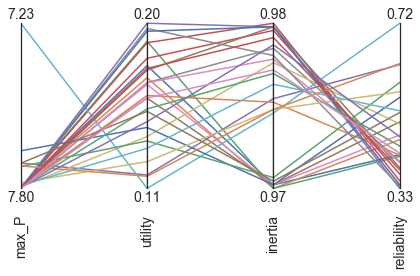

In [131]:
outcomes3 = results3.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits3 = parcoords.get_limits(outcomes3)
axes3 = parcoords.ParallelAxes(limits3)
axes3.plot(outcomes3)

# we invert this axis so direction of desirability is the same 
axes3.invert_axis('max_P') 
plt.show()

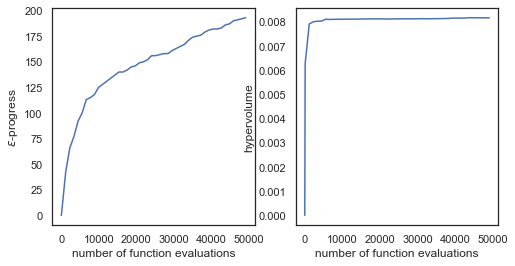

In [132]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence3.nfe, convergence3.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence3.nfe, convergence3.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


<font color='green'>For re-evaluation under deep uncertainty, we would select from each scenario 6 policies which consist of:
1. A policy resulting in max max_P
2. A policy resulting in min max_P
3. A policy resulting in max reliability
4. A policy resulting in min reliability
5. A policy resulting in max utility
6. A policy resulting in min utility

However, there is a possibility that the same policy results in max max_P and max utility and so on. Therefore, the total number of policies selected may be less than 24. </font>

In [133]:
#selecting policies from Scenario0
sel_idx_0 = [results0['max_P'].argmax(), results0['reliability'].argmax(),
             results0['utility'].argmax(), results0['max_P'].argmin(),
             results0['reliability'].argmin(), results0['utility'].argmin()]
sel_idx_0

[4, 8, 4, 8, 4, 8]

In [134]:
sel_idx_0 = list(set(sel_idx_0)) #select only unique indexes
sel_pol_0 = results0.iloc[sel_idx_0]
sel_pol_0

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
8,0.245101,-0.720563,1.992815,1.932839,0.944728,9.302541,0.132494,0.9727,0.6634
4,0.348188,-0.713731,1.980007,1.906213,0.909521,9.570848,0.199138,0.9753,0.4105


In [135]:
#selecting policies from Scenario1
sel_idx_1 = [results1['max_P'].argmax(), results1['reliability'].argmax(),
             results1['utility'].argmax(), results1['max_P'].argmin(),
             results1['reliability'].argmin(), results1['utility'].argmin()]
sel_idx_1

[17, 4, 26, 4, 26, 4]

In [136]:
sel_idx_1 = list(set(sel_idx_1)) #select only unique indexes
sel_pol_1 = results1.iloc[sel_idx_1]
sel_pol_1

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
17,-1.423971,0.237758,1.696097,1.997387,0.01948,9.733204,0.195713,0.9757,0.2827
26,-1.432561,0.237758,1.696097,1.997009,0.01948,9.732251,0.199132,0.9754,0.2785
4,-1.260182,0.220436,1.770854,1.976581,0.01764,9.282334,0.104947,0.9741,0.6496


In [138]:
#selecting policies from Scenario2
sel_idx_2 = [results2['max_P'].argmax(), results2['reliability'].argmax(),
             results2['utility'].argmax(), results2['max_P'].argmin(),
             results2['reliability'].argmin(), results2['utility'].argmin()]
sel_idx_2

[7, 19, 14, 19, 11, 19]

In [139]:
sel_idx_2 = list(set(sel_idx_2)) #select only unique indexes
sel_pol_2 = results2.iloc[sel_idx_2]
sel_pol_2

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
11,0.341888,-0.566269,1.951188,1.584354,0.899701,8.033165,0.195725,0.9771,0.2658
19,0.385196,0.101483,1.982636,1.500843,0.988361,8.026621,0.111929,0.9728,0.4802
14,-0.088891,-0.320477,1.975412,1.480704,0.885881,8.036183,0.195868,0.9779,0.2699
7,0.153307,-0.416925,1.548008,1.345377,0.913293,8.036422,0.182187,0.9763,0.2893


In [140]:
#selecting policies from Scenario3
sel_idx_3 = [results3['max_P'].argmax(), results3['reliability'].argmax(),
             results3['utility'].argmax(), results3['max_P'].argmin(),
             results3['reliability'].argmin(), results3['utility'].argmin()]
sel_idx_3

[3, 9, 14, 9, 14, 9]

In [141]:
sel_idx_3 = list(set(sel_idx_3)) #select only unique indexes
sel_pol_3 = results3.iloc[sel_idx_3]
sel_pol_3

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
9,-0.250952,0.407504,1.940320,1.975915,0.318787,7.227474,0.111920,0.9747,0.7196
3,-0.351801,0.316007,1.874585,1.758856,0.325655,7.798755,0.188452,0.9772,0.3482
14,-0.431975,0.370032,1.987484,1.817012,0.294140,7.798434,0.198693,0.9771,0.3302


In [142]:
#concatenating all selected policies
sel_pols = pd.concat([sel_pol_0, sel_pol_1, sel_pol_2, sel_pol_3], axis=0, ignore_index=True)
sel_pols = sel_pols.loc[:,['c1','c2','r1','r2','w1']]
sel_pols

,c1,c2,r1,r2,w1
0,0.245101,-0.720563,1.992815,1.932839,0.944728
1,0.348188,-0.713731,1.980007,1.906213,0.909521
2,-1.423971,0.237758,1.696097,1.997387,0.019480
3,-1.432561,0.237758,1.696097,1.997009,0.019480
4,-1.260182,0.220436,1.770854,1.976581,0.017640
5,0.341888,-0.566269,1.951188,1.584354,0.899701
6,0.385196,0.101483,1.982636,1.500843,0.988361
7,-0.088891,-0.320477,1.975412,1.480704,0.885881
8,0.153307,-0.416925,1.548008,1.345377,0.913293
9,-0.250952,0.407504,1.940320,1.975915,0.318787


In [143]:
policies = []
for i in range(len(sel_pols)):
    c1 = sel_pols.iloc[i,0]
    c2 = sel_pols.iloc[i,1]
    r1 = sel_pols.iloc[i,2]
    r2 = sel_pols.iloc[i,3]
    w1 = sel_pols.iloc[i,4]
    policies.append(Policy(f"{i}",**{"c1": c1, "c2": c2, "r1": r1, "r2": r2, "w1": w1}))
policies

[Policy({'c1': 0.2451012090260547, 'c2': -0.7205634655439224, 'r1': 1.9928146400898037, 'r2': 1.9328389078361492, 'w1': 0.9447278241364001}),
 Policy({'c1': 0.3481878532421422, 'c2': -0.7137312648929658, 'r1': 1.9800071517333535, 'r2': 1.9062125321451255, 'w1': 0.9095206276739425}),
 Policy({'c1': -1.4239714523356009, 'c2': 0.23775765499242849, 'r1': 1.6960970848571455, 'r2': 1.9973866287031985, 'w1': 0.019479694555848796}),
 Policy({'c1': -1.4325610978228245, 'c2': 0.23775765499242849, 'r1': 1.6960970848571455, 'r2': 1.997008561588363, 'w1': 0.019479694555848796}),
 Policy({'c1': -1.260181936912161, 'c2': 0.22043579126976093, 'r1': 1.7708540180622971, 'r2': 1.976580838214454, 'w1': 0.017639596129617026}),
 Policy({'c1': 0.3418880302739494, 'c2': -0.5662687288761081, 'r1': 1.951187607331191, 'r2': 1.584354471527929, 'w1': 0.8997007580296463}),
 Policy({'c1': 0.38519626452002764, 'c2': 0.10148272227249372, 'r1': 1.9826364754831654, 'r2': 1.5008425758538095, 'w1': 0.988360556387482}),
 P

In [144]:
with MultiprocessingEvaluator(model) as evaluator:
    polresults = perform_experiments(model, 1000, policies, evaluator=evaluator)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 12 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [145]:
polexperiments, poloutcomes = polresults

In [146]:
poloutcomes=pd.DataFrame(poloutcomes)

In [147]:
poloutcomes['policies']=polexperiments['policy']

In [148]:
poloutcomes

,max_P,utility,inertia,reliability,policies
0,8.264152,0.520993,0.9734,0.1758,0
1,0.076555,0.108747,0.9900,1.0000,0
2,6.149126,0.428226,0.9736,0.1917,0
3,0.238447,0.114396,0.9900,1.0000,0
4,0.059750,0.103808,0.9900,1.0000,0
...,...,...,...,...,...
11995,0.241773,0.123555,0.9900,1.0000,11
11996,3.955125,0.596198,0.9779,0.1014,11
11997,5.048799,0.650183,0.9736,0.1866,11
11998,0.124478,0.104659,0.9900,1.0000,11


C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


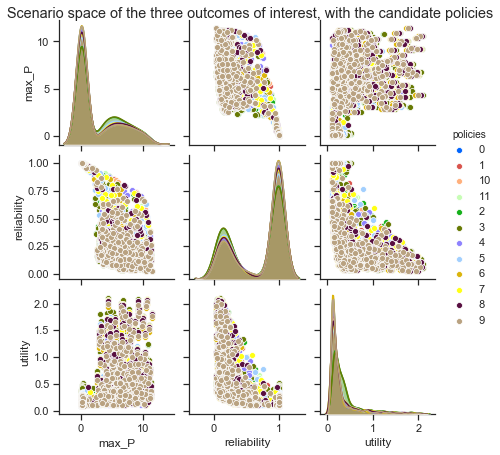

In [149]:
sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["bright blue", "pale red", "peach", "pale green", 
          "green", "olive green", "periwinkle", "baby blue", 
          "gold", "yellow", "plum", "taupe", "grey",
          "teal", "mauve", "beige", "salmon", "mustard"]

gpol = sns.pairplot(poloutcomes, hue='policies', size=2, palette=sns.xkcd_palette(colors), vars=oois)

plt.suptitle("Scenario space of the three outcomes of interest, with the candidate policies", y=1.02)

tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}   

#g.savefig('./figs/mordm/scatter_diverse_random_prim.png', dpi=600)
plt.show()

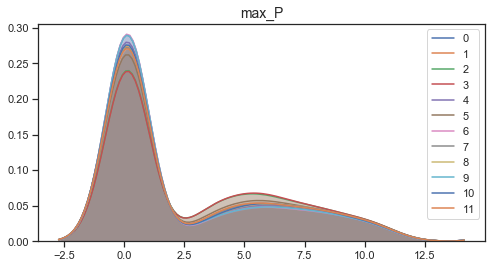

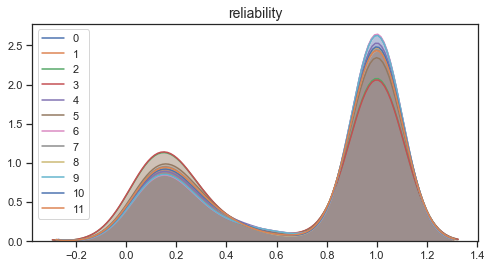

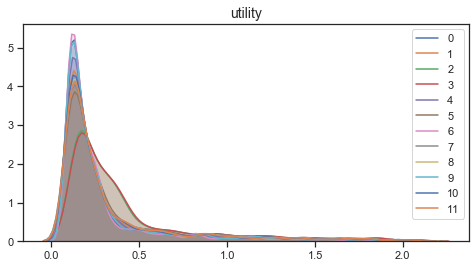

In [150]:
fig, axmaxP = plt.subplots(figsize=(8,4))
fig, axrel = plt.subplots(figsize=(8,4))
fig, axutil = plt.subplots(figsize=(8,4))
axmaxP.set_title('max_P', size=14)
axrel.set_title('reliability', size=14)
axutil.set_title('utility', size=14)

for policy in range(len(policies)):
        sns.kdeplot(poloutcomes.loc[(poloutcomes['policies']==str(policy)),'max_P'], 
                ax=axmaxP, shade=True, Label=policy)  

for policy in range(len(policies)):
        sns.kdeplot(poloutcomes.loc[(poloutcomes['policies']==str(policy)),'reliability'], 
                ax=axrel, shade=True, Label=policy)  

for policy in range(len(policies)):
        sns.kdeplot(poloutcomes.loc[(poloutcomes['policies']==str(policy)),'utility'], 
                ax=axutil, shade=True, Label=policy)  

plt.show()

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

Visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


<font color='green'>The domain criterion provided in Bartholomew and Kwakkel (2020) was for best-cases scenarios policies. While here, our aim is to observe the related policies that may lead to worst cases. Therefore, we need to inverse the domain criterion as follows.
- Utility: 0.25
- Reliability: 0.2
- Inertia: 0.01
</font>

In [98]:
import functools

percentile25 = functools.partial(np.percentile, q=25)
percentile20 = functools.partial(np.percentile, q=20)
percentile1 = functools.partial(np.percentile, q=1)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustness_functions = [ScalarOutcome('20th percentile reliability', kind=MINIMIZE,
                             variable_name='reliability', function=percentile20),
                        ScalarOutcome('1th percentile inertia', kind=MINIMIZE,
                             variable_name='inertia', function=percentile1),
                        ScalarOutcome('25th percentile utility', kind=MINIMIZE,
                             variable_name='utility', function=percentile25)]

In [99]:
nfe = 5000
with MultiprocessingEvaluator(model) as evaluator:
    robust_results = evaluator.robust_optimize(robustness_functions, worstcases,
                            nfe=nfe, epsilons=[0.03, 0.002, 0.002, 0.002])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 498/5000 nfe
[MainProcess/INFO] generation 10: 989/5000 nfe
[MainProcess/INFO] generation 15: 1486/5000 nfe
[MainProcess/INFO] generation 20: 1979/5000 nfe
[MainProcess/INFO] generation 25: 2470/5000 nfe
[MainProcess/INFO] generation 30: 2961/5000 nfe
[MainProcess/INFO] generation 35: 3458/5000 nfe
[MainProcess/INFO] generation 40: 3955/5000 nfe
[MainProcess/INFO] generation 45: 4452/5000 nfe
[MainProcess/INFO] generation 50: 4945/5000 nfe
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


In [100]:
robust_results

,c1,c2,r1,r2,w1,20th percentile reliability,1th percentile inertia,25th percentile utility
0,-0.618860,-0.167359,1.938345,0.733855,0.268611,0.02984,0.969803,0.525506
1,0.416292,0.392610,1.932279,1.973971,0.990896,0.03594,0.971215,0.325863
2,0.433688,-0.133762,1.999115,1.772517,0.999995,0.03604,0.972900,0.323978
3,-0.285296,-0.160224,1.959934,0.673406,0.196382,0.03000,0.969803,0.519154
4,0.616607,-0.142020,1.999874,1.940388,0.999995,0.02960,0.970236,0.345950


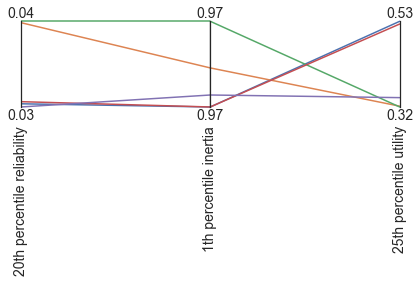

In [110]:
roboutcomes = robust_results.loc[:, ['20th percentile reliability','1th percentile inertia','25th percentile utility']]

roblimits = parcoords.get_limits(roboutcomes)
robaxes = parcoords.ParallelAxes(roblimits)
robaxes.plot(roboutcomes)

plt.show()

In [101]:
def calculate_maxregret(data, obj, n_sol):
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(n_sol)]
    max_regrets = np.max(regrets, axis=1)
    return max_regrets


In [102]:
#[outcome.kind for outcome in outcomes]
ooi_obj ={ooi.name: ooi.kind for ooi in model.outcomes}
print(ooi_obj)

{'max_P': 1, 'utility': -1, 'inertia': -1, 'reliability': -1}


In [104]:
n_sol = len(policies)
n_sol

20

In [109]:
#for ooi, obj in ooi_obj.items():
#    for pol in range(n_sol):
#        rob = calculate_maxregret(poloutcomes[ooi][poloutcomes['policies']==str(pol)], obj, n_sol)
#rob
calculate_maxregret(poloutcomes['max_P'][poloutcomes['policies']=='1'], 1, n_sol)

AxisError: axis 1 is out of bounds for array of dimension 1

### BEHIND THE SCENE

In [95]:
import matplotlib.gridspec as gridspec
import seaborn as sns
def make_grid_den(oois):
    grid = gridspec.GridSpec(2, 2) 
    grid.update(wspace = 0.2,
                hspace = 0.3)
    
    figure = plt.figure()
    figure.set_figheight(9)
    figure.set_figwidth(12)

    axes = {}
    axes[oois[0]] = figure.add_subplot(grid[0,0])
    axes[oois[1]] = figure.add_subplot(grid[0,1])
    axes[oois[2]] = figure.add_subplot(grid[1,0])
    #axes[oois[3]] = figure.add_subplot(grid[1,1])
    
    
    for ooi in oois:
        axes[ooi].set_title(ooi, size=14)

    
    return figure, axes


def plot_kdes_forselected(objectives, scenarios, oois, fn, title):
    
    fig, axes = make_grid_den(oois)
    colors = ['grey', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    labels = []
    some_identifiers = []
    for ooi in oois:
        for i, key in enumerate(scenarios):
            data = objectives[key][ooi]
            sns.kdeplot(data, ax=axes[ooi], legend=False, color=colors[i])
            if ooi == 'inertia': #to have them only once
                labels.append("Scenario {}".format(key))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i], alpha=0.7)
                some_identifiers.append(artist)      
    
    plt.legend(some_identifiers, labels, loc=2, bbox_to_anchor=(1.05, 1.4), borderaxespad=0., fontsize=13)
    
    fig.suptitle(title, fontsize=14)
    #fig.subplots_adjust(right=0.75)
    save_fig(fig, dir = './figs/mordm', name="{}.png".format(title))
    plt.show()

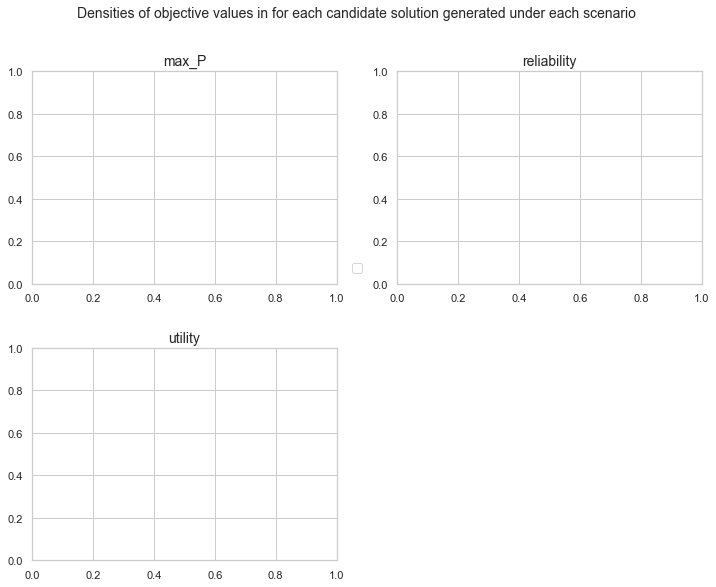

In [97]:
sns.set_style("whitegrid")
fig, axes = make_grid_den(oois)
labels = []
some_identifiers = []   
#colors = ['black', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
clrs = ['black']+colors
for ooi in oois:
    for i, s in enumerate(scenarios):
        indices = np.array([p_name.startswith(str(s)) for p_name in polexperiments['policy']])
        scenario_outcomes = poloutcomes[ooi][indices]
        no_sol = int(len(scenario_outcomes)/1000)
        for sol in range(no_sol):
            end = 1000*(sol+1)
            data = scenario_outcomes[sol:end]
            sns.kdeplot(data, ax=axes[ooi], color=clrs[i], linewidth=0.7, alpha=0.8)
        if ooi == 'inertia': #to have them only once
            labels.append("Scenario {}".format(scenario_tags[s]))
            artist = plt.Rectangle((0,0), 1,1, edgecolor=clrs[i], facecolor=clrs[i], alpha=0.8)
            some_identifiers.append(artist)
    
plt.legend(some_identifiers, labels, loc=2, bbox_to_anchor=(1.05, 1.4), borderaxespad=0., fontsize=13)

fig.suptitle("Densities of objective values in for each candidate solution generated under each scenario", fontsize=14)
#save_fig(fig, dir = './figs/mordm', name="Densities_scenario_solns_revision.png")
#plt.savefig('./figs/mordm/Densities_scenario_solns_v6_v2.png', dpi=300, b_box_inches='tight')
plt.show()

In [68]:
#here, the policy-relevant scenarios defined by median thresholds are selected
indices = []
for ooi in oois:
    if ooi in ['max_P']:
        a = outcomes[ooi] > np.median(outcomes[ooi])     
    else: 
        a = outcomes[ooi] < np.median(outcomes[ooi])
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.all() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

Next, the four particular scenarios that we want to look at are:
1. The scenario whose highest max_P
2. The scenario whose lowest reliability
3. The scenario whose lowest utility
4. The scenario

In [ ]:
#
m=newoutcomes.sort_values(by=0)
m

In [78]:
np.percentile(outcomes['max_P'], 90) # return 10th percentile

8.35751148210897

In [66]:
np.median(outcomes['reliability']) 

0.07999999999999996

In [47]:
with MultiprocessingEvaluator(model) as evaluator:
    new_results, new_convergence = evaluator.optimize(nfe=1000, searchover='uncertainties',
                                    epsilons=[0.01, 0.01, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 498/1000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 993/1000 nfe
[MainProcess/DEBUG] none received
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [48]:
 new_results

,b,q,mean,stdev,delta,max_P,utility,inertia,reliability
0,0.185784,3.587037,0.041482,0.002730,0.932367,6.137322,0.232790,0.9725,0.2406
1,0.185784,3.587037,0.041902,0.001629,0.934150,6.138966,0.245317,0.9734,0.2362
2,0.149966,3.462564,0.029113,0.002590,0.935966,7.522502,0.241980,0.9724,0.2475


In [168]:
# as we want to examine the worst cases, we need to change the outcomes' kind so the direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

In [189]:
with MultiprocessingEvaluator(model) as evaluator:
    results0, convergence0 = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.001, 0.001, 0.001, 0.001],
                                    reference=worstcases[0],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 499/10000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 992/10000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 15: 1491/10000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 20: 1985/10000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEB

[MainProcess/DEBUG] [Solution[0.8657652961942014,0.6759613638760268,1.8698864547665917,1.5779530131731518,0.09247270382892134|9.555256269522621,0.378800511537286,0.9707000000000015,0.030000000000000075|0.0], Solution[0.8782692288018039,0.7948725444221361,1.8098164740853568,1.678100994281654,0.009464976983957651|9.556895430344698,0.41083170885707404,0.9742000000000012,0.028900000000000058|0.0]]
[MainProcess/DEBUG] [Solution[0.9096105718688432,0.7962972160918944,1.8741174624770496,1.9113608208106934,0.796436840225753|9.557088018360687,0.41557699937921977,0.9756000000000012,0.02610000000000002|0.0], Solution[0.8782692288018039,0.7956386405642415,1.8098164740853568,1.674412420011238,0.006731911845823667|9.556134509389114,0.4115556730430617,0.9726000000000012,0.02890000000000005|0.0]]
[MainProcess/DEBUG] [Solution[0.9291851564799769,0.955972986711634,1.9578100172486947,1.7625651912121973,0.8730119537060282|9.55601366819505,0.4228208527375875,0.9703000000000016,0.01999999999999999|0.0], Solu

[MainProcess/DEBUG] [Solution[0.7350538799238081,0.8298505842815532,1.9214191748031284,1.7345636398941051,0.00010293597927187037|9.555374696912352,0.41493737699566885,0.9718000000000014,0.025900000000000038|0.0], Solution[0.9330273264506448,0.6729621699932014,1.998855696489439,1.5779530131731518,0.036198664718273765|9.556228828063723,0.37541656786688554,0.9729000000000014,0.030000000000000075|0.0]]
[MainProcess/DEBUG] [Solution[0.8700442118326055,0.7945118934926381,1.751279973478703,1.6574151261829209,0.06997853029152018|9.556345295176145,0.4147091273168522,0.9704000000000015,0.02670000000000002|0.0], Solution[0.8654206976606631,0.9862344208896545,1.9238739915436769,1.7523104099485673,0.7504622602622449|9.557116390160107,0.4219049690016006,0.9700000000000015,0.020599999999999986|0.0]]
[MainProcess/DEBUG] [Solution[0.8636822528495192,0.5417165751981983,1.8986209990048124,1.5624903463365893,0.6178181725007407|9.556063499877666,0.37910331262339225,0.9702000000000015,0.030000000000000075|0

[MainProcess/DEBUG] [Solution[0.9291851564799769,0.955972986711634,1.9578100172486947,1.7625651912121973,0.8730119537060282|9.55601366819505,0.4228208527375875,0.9703000000000016,0.01999999999999999|0.0], Solution[0.8782692288018039,0.7948725444221361,1.8098164740853568,1.678100994281654,0.009464976983957651|9.556895430344698,0.41083170885707404,0.9742000000000012,0.028900000000000058|0.0]]
[MainProcess/DEBUG] [Solution[0.9120943105552133,1.0419695991336644,1.8908691513252305,1.9819039690457418,0.9088816760950666|9.557011036440697,0.424320151835674,0.9700000000000015,0.01999999999999999|0.0], Solution[-0.0739805311032431,0.7756408114947013,1.9897769201880449,1.6510090136686597,0.006731911845823667|9.555617295765002,0.40789321788031657,0.9770000000000011,0.029800000000000076|0.0]]
[MainProcess/DEBUG] [Solution[1.0024018577527767,0.7972895876868461,1.996252571524243,1.7023033457662997,0.01287421605099992|9.55631919848219,0.40887869048035264,0.9772000000000012,0.029700000000000074|0.0], S

In [25]:
results0

NameError: name 'results0' is not defined

In [190]:
convergence0

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.000919,6,100
2,0.001382,80,1191
3,0.001409,150,2281
4,0.001414,178,3373
5,0.001415,206,4462
6,0.001415,227,5554
7,0.001416,242,6636
8,0.001418,258,7728
9,0.001418,267,8818


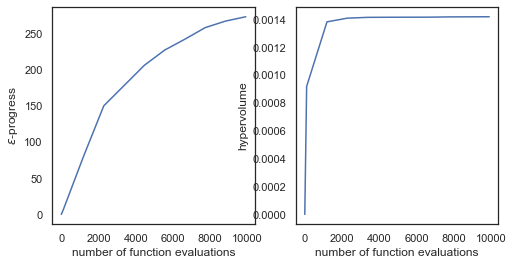

In [193]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence0.nfe, convergence0.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence0.nfe, convergence0.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [84]:
sns.set_style("whitegrid")

def plot_robustness_regret(data, scenarios, labels, title, fn, colors):
    df_minima = pd.DataFrame([np.min(data[s], axis=0) for s in scenarios])
    df_maxima = pd.DataFrame([np.max(data[s], axis=0) for s in scenarios])
    minima = np.min(df_minima, axis=0)
    maxima = np.max(df_maxima, axis=0)
    #print(maxima)
    new_labels=[]
    for ooi in labels:
        new_labels.append("Robustness\nof {}".format(ooi))
    axes = setup_parallel_plot(labels, maxima, minima, new_labels)
    # put vertical arrows near the labels here!!!
    for j, label in enumerate(labels): 
        x_arrow = j+1.3
        if j < len(labels)-1:
            ax = axes[j]
        else:
            ax = axes[j-1]

        ax.arrow(x_arrow,-.15,0.,-0.1,fc='black',ec='black', lw=1.5, clip_on=False, length_includes_head=True,
                    head_length=0.03, head_width=0.05)

    normed_data = {}
    for key in scenarios:
        normed_data[key] = normalize(data[key], minima, maxima)
        normed_data[key] = normed_data[key].sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df

    fig = plt.gcf()

    #colors = ['black', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    #colors = colors + 4*['lightgrey']
    plabels = []
    some_identifiers = []
    
    for j in range(len(labels)-1): #df_outcomes.shape[1]-1
        ax = axes[j]        
        for i, key in enumerate(scenarios):
            y = normed_data[key].ix[:, j:j+2]
            #if key == 'Ref':
            #    print(y)
            x = np.tile([j+1,j+2], (y.shape[0], 1))
            ax.plot(x.T, y.T, color=colors[i], linewidth=1.5)
            #ax.axhline(y=0.5, linewidth=3, color='r')
            #for legend
            if j == 0:
                #plabels.append("Scenario {}".format(scenario_tags[key]))
                plabels.append("{}".format(key))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i])
                some_identifiers.append(artist)
        
    
    plt.legend(some_identifiers, plabels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)

    change_fontsize(fig, 14)
    fig.suptitle(title, fontsize=20)
    save_fig(fig, dir = './figs/mordm', name=fn)
    plt.show()

def calculate_maxregret(data, obj, n_sol):
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(n_sol)]
    max_regrets = np.max(regrets, axis=1)
    return max_regrets

In [85]:
reg_results = {}
for scenario, value in decisions.items():
    reg_results[scenario] = value.copy()     

In [89]:
reg_results

{333: c1    0.791712
 c2     -1.2897
 r1    0.595351
 r2     1.78915
 w1     0.14994
 Name: 333, dtype: object,
 644: c1    0.791712
 c2     -1.2897
 r1    0.595351
 r2     1.78915
 w1     0.14994
 Name: 644, dtype: object,
 668: c1    0.791712
 c2     -1.2897
 r1    0.595351
 r2     1.78915
 w1     0.14994
 Name: 668, dtype: object,
 881: c1    0.791712
 c2     -1.2897
 r1    0.595351
 r2     1.78915
 w1     0.14994
 Name: 881, dtype: object}

In [87]:
#[outcome.kind for outcome in outcomes]
ooi_obj ={ooi.name: ooi.kind for ooi in model.outcomes}
print(ooi_obj)

{'max_P': 1, 'utility': -1, 'inertia': -1, 'reliability': -1}


In [88]:
for ooi, obj in ooi_obj.items():
    for i, s in enumerate(scenarios):
        #indices = np.array([p_name.startswith(str(s)) for p_name in experimentsC['policy']])
        #scenario_outcomes = outcomesC[ooi][indices]
        #no_sol = int(len(scenario_outcomes)/1000)
        data = []
        for sol in reg_results[s].index:
            data_p = outcomes[ooi][experiments['policy'] == str(s)+'_'+str(sol)]
            #if data_p.shape[0]:
            data.append(data_p)
        rob = calculate_maxregret(data, obj, len(reg_results[s].index))
        for i,sol in enumerate(reg_results[s].index):
            reg_results[s].set_value(sol, ooi, rob[i])
    
    for i, s in enumerate(random_selected):
        data = []
        for sol in reg_results[s].index:
            data_p = outcomes_r[ooi][experiments_r['policy'] == str(s)+'_'+str(sol)]
            data.append(data_p)
        rob = calculate_maxregret(data, obj, len(reg_results[s].index))
        for i,sol in enumerate(reg_results[s].index):
            reg_results[s].set_value(sol, ooi, rob[i])

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plot_robustness_regret(reg_results, scenarios, sorted(oois), 
                "Robustness trade-offs with maximum regret", 
                "MaxRegret_revision_nfe10000.png", colors)

In [ ]:
frames = [reg_results[s] for s in [2313, 2754, 2776, 2874]] #excluding the reference scenario
reg_diverse = pd.concat(frames, ignore_index=True)

In [ ]:
data = {'systematic':reg_diverse,
        'random' : reg_random}
plot_robustness_regret(data, ['systematic', 'random'], sorted(oois), 
                "Robustness of candidate solutions (Max regret)",
                "Random_regret.png", ['black', 'lightgrey'])